### **Implementasi Algoritma k-Nearest Neighbors untuk Klasifikasi Penerima Bantuan Sosial Tepat Sasaran Berdasarkan Indikator Ekonomi Keluarga**

##### 1. Tahap pertama, saya memanggil pustaka yang dibutuhkan untuk memproses data. Di sini saya menggunakan Pandas untuk manipulasi data tabel, Numpy untuk operasi numerik, dan MinMaxScaler dari Scikit-Learn.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("Library berhasil di-import!")

Library berhasil di-import!


##### 2. Selanjutnya, saya membaca dataset asli yang bersumber dari Kaggle. File ini berisi data mentah kondisi ekonomi dan sosial penduduk yang akan saya gunakan sebagai basis pengetahuan sistem.

In [4]:
# Membaca file CSV
try:
    df = pd.read_csv('data_bansos.csv')
    print("Data Kaggle berhasil dimuat!")
    print(f"Ukuran Data Asli: {df.shape[0]} baris, {df.shape[1]} kolom")
except FileNotFoundError:
    print("ERROR: File 'data_bansos.csv' tidak ditemukan. Pastikan sudah didownload dan direname.")

Data Kaggle berhasil dimuat!
Ukuran Data Asli: 9557 baris, 143 kolom


##### 3. Dataset asli memiliki banyak kolom yang tidak semuanya relevan. Oleh karena itu, saya melakukan seleksi fitur dan mengambil kolom yang sesuai dengan variabel penelitian saya, yaitu: Penghasilan (dari kolom biaya sewa/ekonomi), Tanggungan (dari jumlah anggota keluarga anak-anak), Kondisi Rumah (dari keberadaan plafon/langit-langit), Label Asli (Target kemiskinan dari dataset).

In [5]:
# Mengambil hanya kolom yang dibutuhkan
df_selected = df[['v2a1', 'hogar_nin', 'cielorazo', 'Target']].copy()

# Mengganti nama kolom menjadi bahasa Indonesia
df_selected.columns = ['Penghasilan', 'Tanggungan', 'Kondisi_Rumah', 'Label_Asli']

print("Cuplikan data setelah seleksi kolom:")
df_selected.head()

Cuplikan data setelah seleksi kolom:


,Penghasilan,Tanggungan,Kondisi_Rumah,Label_Asli
0,190000.0,0,1,4
1,135000.0,0,1,4
2,NaN,0,1,4
3,180000.0,2,1,4
4,180000.0,2,1,4


##### 4. Setelah memeriksa data, saya menemukan beberapa nilai kosong yang dapat mengganggu perhitungan. Di tahap ini, saya mengisi nilai kosong pada kolom Penghasilan dengan angka 0 agar data menjadi lengkap dan siap diolah.

In [6]:
# Mengisi nilai kosong (NaN) pada kolom Penghasilan dengan angka 0
df_selected['Penghasilan'] = df_selected['Penghasilan'].fillna(0)

print("Cek apakah masih ada data kosong:")
print(df_selected.isnull().sum())

Cek apakah masih ada data kosong:
Penghasilan      0
Tanggungan       0
Kondisi_Rumah    0
Label_Asli       0
dtype: int64


##### 5. Untuk memenuhi kebutuhan spesifikasi sistem SPK yang mensyaratkan 5 kriteria lengkap, saya menambahkan dua atribut pelengkap yaitu Daya Listrik dan Skor Aset. Penambahan ini dilakukan secara simulasi rasional untuk melengkapi struktur dataset agar sesuai dengan metode KNN yang saya bangun.

In [7]:
# Mengatur seed agar hasil acak tetap konsisten setiap kali dijalankan
np.random.seed(42)

# Menambah kolom Daya Listrik (Pilihan: 450, 900, atau 1300 VA)
df_selected.insert(2, 'Daya_Listrik', np.random.choice([450, 900, 1300], size=len(df_selected)))

# Menambah kolom Skor Aset (Rentang nilai acak 10 - 100)
df_selected.insert(4, 'Aset', np.random.randint(10, 100, size=len(df_selected)))

print("Data setelah penambahan fitur Listrik & Aset:")
df_selected.head()

Data setelah penambahan fitur Listrik & Aset:


,Penghasilan,Tanggungan,Daya_Listrik,Kondisi_Rumah,Aset,Label_Asli
0,190000.0,0,1300,1,86,4
1,135000.0,0,450,1,64,4
2,0.0,0,1300,1,45,4
3,180000.0,2,1300,1,98,4
4,180000.0,2,450,1,33,4


##### 6. Target asli dari dataset memiliki 4 tingkatan kemiskinan. Untuk menyederhanakan keputusan SPK, saya mengelompokkannya menjadi dua kelas biner: Nilai 1 (Layak): Untuk kategori kemiskinan ekstrem hingga rentan. Nilai 0 (Tidak Layak): Untuk kategori tidak rentan (mampu).

In [8]:
# Logika transformasi: Jika Label_Asli <= 3 maka 1, selain itu 0
df_selected['Status'] = np.where(df_selected['Label_Asli'] <= 3, 1, 0)

# Hapus kolom Label_Asli karena sudah tidak dipakai
df_selected = df_selected.drop(columns=['Label_Asli'])

print("Sebaran Data Target (0 vs 1):")
print(df_selected['Status'].value_counts())

Sebaran Data Target (0 vs 1):
Status
0    5996
1    3561
Name: count, dtype: int64


##### 7. Ini adalah tahap paling krusial. Mengingat algoritma KNN menghitung jarak antar data, perbedaan skala angka (misalnya Gaji jutaan vs Tanggungan satuan) akan menyebabkan bias. Oleh karena itu, saya melakukan Normalisasi Min-Max untuk mengubah semua nilai atribut ke dalam rentang 0.0 hingga 1.0. Data inilah yang nantinya akan masuk ke perhitungan manual.

In [9]:
scaler = MinMaxScaler()

# Daftar kolom yang akan dinormalisasi
fitur = ['Penghasilan', 'Tanggungan', 'Daya_Listrik', 'Kondisi_Rumah', 'Aset']

# Proses normalisasi
df_selected[fitur] = scaler.fit_transform(df_selected[fitur])

print("Hasil Data Ternormalisasi (Siap Hitung):")
df_selected.head()

Hasil Data Ternormalisasi (Siap Hitung):


,Penghasilan,Tanggungan,Daya_Listrik,Kondisi_Rumah,Aset,Status
0,0.080732,0.000000,1.0,1.0,0.853933,0
1,0.057362,0.000000,0.0,1.0,0.606742,0
2,0.000000,0.000000,1.0,1.0,0.393258,0
3,0.076483,0.222222,1.0,1.0,0.988764,0
4,0.076483,0.222222,0.0,1.0,0.258427,0


##### 8. Terakhir, data yang sudah bersih, lengkap, dan ternormalisasi saya simpan ke dalam file baru bernama 'data_bersih_siap_native.csv'. File inilah yang akan dibaca oleh sistem aplikasi utama untuk proses klasifikasi selanjutnya.

In [10]:
nama_file_output = 'data_bansos_bersih.csv'
df_selected.to_csv(nama_file_output, index=False)

print(f"SUKSES! Data bersih disimpan ke '{nama_file_output}'")

SUKSES! Data bersih disimpan ke 'data_bansos_bersih.csv'


##### 9. Setelah data siap, saya memasuki tahap Evaluasi Model. Sesuai teori pengujian sistem klasifikasi, saya membagi dataset menjadi dua bagian: Data Latih (Training Set): Sebanyak 80% data digunakan sebagai basis pengetahuan (Knowledge Base) untuk algoritma KNN. Data Uji (Testing Set): Sebanyak 20% data disisihkan untuk menguji keakuratan prediksi sistem.

In [11]:
from sklearn.model_selection import train_test_split
# Import fungsi native yang sudah kita buat di file sebelah
# Pastikan file 'logika_knn.py' ada di satu folder dengan notebook ini
from logika_knn import prediksi_native

# Menggunakan dataframe 'df_selected' yang sudah dinormalisasi dari tahap sebelumnya
X = df_selected.iloc[:, :-1].values  # Fitur
y = df_selected.iloc[:, -1].values   # Label Status

# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gabungkan kembali fitur+label untuk menjadi format Database Native (List)
train_set = np.column_stack((X_train, y_train)).tolist()

print(f"Total Data: {len(df_selected)}")
print(f"Data Latih: {len(X_train)} baris")
print(f"Data Uji  : {len(X_test)} baris")

Total Data: 9557
Data Latih: 7645 baris
Data Uji  : 1912 baris


##### 10. Pada tahap ini, saya melakukan simulasi prediksi menggunakan algoritma Native KNN (Manual). Sistem akan memprediksi status kelayakan dari Data Uji satu per satu, lalu hasilnya dibandingkan dengan label yang sebenarnya.
*Catatan: Karena proses ini menghitung jarak secara manual (brute force), saya mengambil sampel 100 data uji untuk mempercepat proses demonstrasi.*

In [12]:
import time

# Ambil sampel 100 data uji saja agar tidak terlalu lama running-nya
limit = 100
X_test_sample = X_test[:limit]
y_test_sample = y_test[:limit]

y_pred_native = []
start_time = time.time()

print(f"Sedang menguji {limit} data secara manual...")

# Loop prediksi satu per satu
for data_uji in X_test_sample:
    # Panggil fungsi Native KNN (K=5)
    hasil = prediksi_native(train_set, data_uji, 5)
    y_pred_native.append(hasil)

end_time = time.time()
print(f"Selesai! Waktu eksekusi: {end_time - start_time:.2f} detik")

Sedang menguji 100 data secara manual...
Selesai! Waktu eksekusi: 3.43 detik


#####  11. Untuk mengukur performa, saya menggunakan Confusion Matrix yang memetakan hasil prediksi menjadi:
* TP (True Positive): Prediksi Layak, Aktual Layak.
* TN (True Negative): Prediksi Tidak, Aktual Tidak.
* FP (False Positive): Prediksi Layak, padahal Aktual Tidak.
* FN (False Negative): Prediksi Tidak, padahal Aktual Layak.

In [13]:
# Menghitung Komponen Confusion Matrix secara Manual
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test_sample)):
    aktual = y_test_sample[i]
    prediksi = y_pred_native[i]
    
    if aktual == 1 and prediksi == 1: TP += 1
    elif aktual == 0 and prediksi == 0: TN += 1
    elif aktual == 0 and prediksi == 1: FP += 1
    elif aktual == 1 and prediksi == 0: FN += 1

print(f"True Positive  (TP): {TP}")
print(f"True Negative  (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

True Positive  (TP): 19
True Negative  (TN): 34
False Positive (FP): 19
False Negative (FN): 28


##### 12. Berdasarkan Confusion Matrix di atas, saya menghitung nilai Akurasi, Presisi, dan Recall untuk mengetahui seberapa handal model Native KNN yang telah dibangun.

In [15]:
# Rumus Evaluasi Manual
akurasi = (TP + TN) / (TP + TN + FP + FN)
presisi = TP / (TP + FP) if (TP+FP) > 0 else 0
recall  = TP / (TP + FN) if (TP+FN) > 0 else 0
f1_score = 2 * (presisi * recall) / (presisi + recall) if (presisi+recall) > 0 else 0

print("=== LAPORAN EVALUASI MODEL (NATIVE CODE) ===")
print(f"Akurasi   : {akurasi * 100:.2f}%")
print(f"Presisi   : {presisi * 100:.2f}%")
print(f"Recall    : {recall * 100:.2f}%")
print(f"F1-Score  : {f1_score * 100:.2f}%")

=== LAPORAN EVALUASI MODEL (NATIVE CODE) ===
Akurasi   : 53.00%
Presisi   : 50.00%
Recall    : 40.43%
F1-Score  : 44.71%


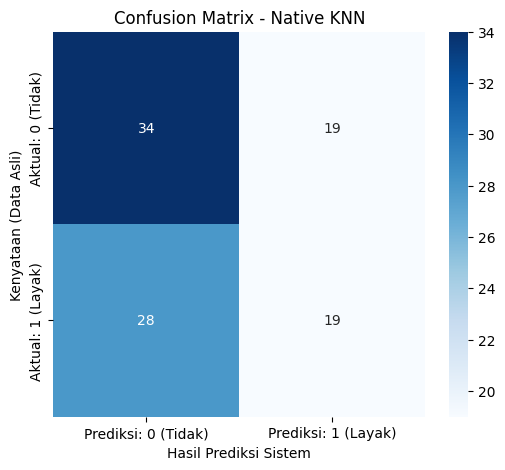

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan variabel TP, TN, FP, FN sudah terhitung dari sel sebelumnya
# Kalau belum, jalankan dulu sel perhitungan evaluasi di atasnya

# Membuat Data untuk Visualisasi
cm = [[TN, FP], 
      [FN, TP]]

# Menggambar Heatmap (Kotak Biru)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prediksi: 0 (Tidak)', 'Prediksi: 1 (Layak)'],
            yticklabels=['Aktual: 0 (Tidak)', 'Aktual: 1 (Layak)'])
plt.xlabel('Hasil Prediksi Sistem')
plt.ylabel('Kenyataan (Data Asli)')
plt.title('Confusion Matrix - Native KNN')
plt.show()